# Validity analysis

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pathlib import Path
import re

from typing import Dict, Any, List, Iterable, Optional


In [106]:
# =============================================================================
# Helpers
# =============================================================================

def feat_id(d: Dict[str, Any]) -> str:
    """Compact feature id: feature_key-granularity_key-encoding_key."""
    return f"{d.get('feature_key', '')}-{d.get('granularity_key', '')}-{d.get('encoding_key', '')}"


def extract_rfe_results(path: Path, dataset: str) -> pd.DataFrame:
    """
    Load RFE JSON (list of records) from `path` and build consolidated base
    dataset exactly like `extract_single_rfe_results`.

    This is literally the merge of `_load_rfe_results` + `extract_single_rfe_results`.
    """
    # === the inline former _load_rfe_results ===
    if not isinstance(path, Path):
        path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"RFE results not found: {path}")
    with path.open("r", encoding="utf-8") as f:
        records = json.load(f)
    if not isinstance(records, list) or not records:
        raise RuntimeError(f"No records found in RFE results JSON: {path}")

    # === former extract_single_rfe_results logic ===
    eliminated_rows: List[Dict[str, Any]] = []
    all_feats: set[str] = set()

    for idx, rec in enumerate(records, start=1):
        metric_key = rec.get("metric_key")
        baseline_metric = rec.get("baseline_metric_value", {})

        for elim in rec.get("eliminated_features", []) or []:
            eliminated_rows.append({
                "feature_id": feat_id(elim),
                "feature_key": elim.get("feature_key"),
                "encoding_key": elim.get("encoding_key"),
                "granularity_key": elim.get("granularity_key"),
                "iteration_removed": idx,
                "timestamp_utc": rec.get("timestamp_utc"),
                "eliminated_feat_metric": elim.get("metrics", {}).get(metric_key, {}),
                "baseline_metric": baseline_metric,
                "metric_key": metric_key,
            })

        for f in rec.get("remaining_elimination_features", []) or []:
            all_feats.add(feat_id(f))

    max_iter = len(records)
    elim_df = pd.DataFrame(eliminated_rows)

    not_removed_ids = sorted(list(all_feats - set(elim_df["feature_id"].tolist() if not elim_df.empty else [])))
    not_removed_rows: List[Dict[str, Any]] = []
    for fid in not_removed_ids:
        parts = fid.split("-", 2)
        not_removed_rows.append({
            "feature_id": fid,
            "feature_key": parts[0] if len(parts) > 0 else "",
            "granularity_key": parts[1] if len(parts) > 1 else "",
            "encoding_key": parts[2] if len(parts) > 2 else "",
            "iteration_removed": max_iter + 1,
            "timestamp_utc": None,
            "eliminated_feat_metric": None,
            "baseline_metric": None,
            "metric_key": metric_key,
        })

    not_removed_df = pd.DataFrame(not_removed_rows)

    if elim_df.empty and not_removed_df.empty:
        raise RuntimeError(f"No features found in RFE results for dataset={dataset}")

    rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
    rank_df = rank_df.sort_values("iteration_removed").reset_index(drop=True)
    rank_df["importance_rank"] = rank_df["iteration_removed"].rank(method="dense", ascending=True).astype(int)
    rank_df["dataset"] = dataset
    return rank_df

def extract_single_results(path: Path, dataset: str) -> pd.DataFrame:
    if not isinstance(path, Path):
        path = Path(path)
    with path.open("r", encoding="utf-8") as f:
        obj = json.load(f)

    # being defensive if "metrics" or "mae" is missing
    try:
        return float(obj["metrics"]["mae"])
    except Exception:
        raise KeyError(f"mae metric not found in: {path}")


## Internal validity

In [107]:
RFE_RESULTS_PATHS = {
    'none / 12h / low': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_none_0-25/pi_rfe_results_20251014T130053Z.json'),
    'daily / 12h / low': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_daily0-3_0-25/pi_rfe_results_20251021T143631Z.json'), 
    'weekly / 12h / low': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_weekly0-2_0-25/pi_rfe_results_20251021T175156Z.json'),
    'monthly / 12h / low': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_monthly0-2_0-25/pi_rfe_results_20251021T212725Z.json'),
    'yearly / 12h / low': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_yearly0-2_0-25_7y/pi_rfe_results_20251022T171121Z.json'),

    'none / 3.5d / low': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_none_0-25/pi_rfe_results_20251014T134737Z.json'),
    'daily / 3.5d / low': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_daily0-6_0-25/pi_rfe_results_20251021T102821Z.json'), 
    'weekly / 3.5d / low': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_weekly0-6_0-25/pi_rfe_results_20251021T130648Z.json'), 
    'monthly / 3.5d / low': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_monthly0-5_0-25/pi_rfe_results_20251021T192131Z.json'), 
    'yearly / 3.5d / low': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_yearly0-35_0-25_7y/pi_rfe_results_20251024T204702Z.json'), 

    'none / 2w / low': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_none_0-25/pi_rfe_results_20251015T055943Z.json'), 
    'daily / 2w / low': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_daily0-5_0-25/pi_rfe_results_20251020T212218Z.json'), 
    'weekly / 2w / low': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_weekly0-5_0-25/pi_rfe_results_20251021T005605Z.json'), 
    'monthly / 2w / low': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_monthly0-7_0-25/pi_rfe_results_20251021T043931Z.json'), 
    'yearly / 2w / low': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_yearly0-4_0-25_7y/pi_rfe_results_20251024T190527Z.json'), 

    'none / 12h / high': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_none_0-50/pi_rfe_results_20251107T121628Z.json'), 
    'daily / 12h / high': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_daily0-3_0-50/pi_rfe_results_20251107T121732Z.json'), 
    'weekly / 12h / high': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_weekly0-2_0-50/pi_rfe_results_20251107T140254Z.json'), 
    'monthly / 12h / high': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_monthly0-2_0-50/pi_rfe_results_20251107T154500Z.json'), 
    'yearly / 12h / high': Path('../artifacts/recursive_feature_elimination/syn/syn_12h_yearly0-2_0-50_7y/pi_rfe_results_20251107T212630Z.json'), 

    'none / 3.5d / high': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_none_0-50/pi_rfe_results_20251107T135608Z.json'),
    'daily / 3.5d / high': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_daily0-6_0-50/pi_rfe_results_20251107T152855Z.json'), 
    'weekly / 3.5d / high': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_weekly0-5_0-50/pi_rfe_results_20251108T171130Z.json'), 
    'monthly / 3.5d / high': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_monthly0-4_0-50/pi_rfe_results_20251107T165416Z.json'), 
    'yearly / 3.5d / high': Path('../artifacts/recursive_feature_elimination/syn/syn_3-5d_yearly0-35_0-50_7y/pi_rfe_results_20251107T212843Z.json'), 

    'none / 2w / high': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_none_0-50/pi_rfe_results_20251107T231921Z.json'), 
    'daily / 2w / high': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_daily0-5_0-50/pi_rfe_results_20251108T003117Z.json'), 
    'weekly / 2w / high': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_weekly0-5_0-50/pi_rfe_results_20251108T015108Z.json'), 
    'monthly / 2w / high': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_monthly0-6_0-50/pi_rfe_results_20251108T102443Z.json'), 
    'yearly / 2w / high': Path('../artifacts/recursive_feature_elimination/syn/syn_2w_yearly0-4_0-50_7y/pi_rfe_results_20251108T131012Z.json'), 
}

In [108]:
def generate_results_paths(directory: str, prefix: str) -> dict:
    """
    Generate a dictionary mapping descriptive keys to Path objects for validation files.

    Keys are in the format:
        "trace_duration / frequency / complexity / event_duration_std"
    
    Event duration risk is determined from filename numeric suffix (_0-25_ -> "low", _0-50_ -> "high").

    Args:
        directory (str): Path to the folder containing files.
        prefix (str): Filename prefix to filter relevant files.

    Returns:
        dict: Keys mapping to Path objects.
    """
    # Trace duation mapping
    trace_duration_map = {
        "12h": "12h",
        "3-5d": "3.5d",
        "2w": "2w"
    }

    # Event duration mapping
    event_duration_std_map = {
        "0-25": "low",
        "0-50": "high"
    }

    directory = Path(directory)
    results_paths = {}

    for file in directory.iterdir():
        if file.is_file() and file.name.startswith(prefix):
            # Remove prefix and extension
            name_part = file.stem[len(prefix):]

            # Split by underscores
            parts = name_part.split("_")

            complexity = "simple"
            trace_duration_raw = parts[0]
            cyclicality_raw = parts[1]
            event_duration_std_raw = parts[2][:4]

            # Clean frequency by removing numeric ranges
            cyclicality = re.sub(r"\d+[-\d+y]*", "", cyclicality_raw)
            # Map trace duration
            trace_duration = trace_duration_map.get(trace_duration_raw, trace_duration_raw)

            # Map numeric suffix to risk level
            event_duration_std = event_duration_std_map.get(event_duration_std_raw, "low")

            # Construct dictionary key
            key = f"{cyclicality} / {trace_duration} / {event_duration_std}"

            # Assign path
            results_paths[key] = file

    return results_paths

In [109]:
guided_directory = "../artifacts/validation/internal/guided_v05_internal/"
guided_prefix = "summary_validation_guided_syn_"

GUIDED_RESULTS_PATHS = generate_results_paths(guided_directory, guided_prefix)
    
# Print summary
#for k, v in GUIDED_RESULTS_PATHS.items():
#    print(f"'{k}': {v},")
print(f"\nTotal entries: {len(GUIDED_RESULTS_PATHS)}")


Total entries: 30


In [110]:
tax_directory = "../artifacts/validation/internal/tax_etal/"
tax_prefix = "summary_validation_tax_syn_"

TAX_RESULTS_PATHS = generate_results_paths(tax_directory, tax_prefix)
    
# Print summary
#for k, v in TAX_RESULTS_PATHS.items():
#    print(f"'{k}': {v},")
print(f"\nTotal entries: {len(TAX_RESULTS_PATHS)}")


Total entries: 30


In [111]:
verenich_directory = "../artifacts/validation/internal/verenich_etal/"
verenich_prefix = "summary_validation_verenich_syn_"

VERENICH_RESULTS_PATHS = generate_results_paths(verenich_directory, verenich_prefix)
    
# Print summary
#for k, v in TAX_RESULTS_PATHS.items():
#    print(f"'{k}': {v},")
print(f"\nTotal entries: {len(VERENICH_RESULTS_PATHS)}")


Total entries: 30


In [112]:
oyamada_directory = "../artifacts/validation/internal/oyamada_etal/"
oyamada_prefix = "summary_validation_oyamada_syn_"

OYAMADA_RESULTS_PATHS = generate_results_paths(oyamada_directory, oyamada_prefix)
    
# Print summary
#for k, v in OYAMADA_RESULTS_PATHS.items():
#    print(f"'{k}': {v},")
print(f"\nTotal entries: {len(OYAMADA_RESULTS_PATHS)}")


Total entries: 30


In [113]:
# Read results from RFE
rows = []
for dataset, path in RFE_RESULTS_PATHS.items():
    rfe_df = extract_rfe_results(path, dataset)
    vals = rfe_df["baseline_metric"].dropna().to_numpy()
    if vals.size == 0:
        rows.append({
            "dataset": dataset,
            "RFE min.": np.nan,
            "RFE p25": np.nan,
            "RFE p50": np.nan,
            "RFE p75": np.nan,
            "RFE max.": np.nan,
            "RFE mean": np.nan,
        })
    else:
        rows.append({
            "dataset": dataset,
            "RFE min.": float(np.min(vals)),
            "RFE p25": float(np.nanpercentile(vals, 25)),
            "RFE p50": float(np.nanpercentile(vals, 50)),
            "RFE p75": float(np.nanpercentile(vals, 75)),
            "RFE max.": float(np.max(vals)),
            "RFE mean": float(np.mean(vals)),
        })

internal_validation_df = pd.DataFrame(rows).set_index("dataset")
#internal_validation_df

C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\3092073739.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\3092073739.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\3092073739.py:75: FutureWarning: The behavior of DataFrame c

In [114]:
# Read results from guided
for dataset, path in GUIDED_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    internal_validation_df.loc[dataset, "Guided"] = mae

In [115]:
# Read results from Tax et al.
for dataset, path in TAX_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    internal_validation_df.loc[dataset, "Tax et al."] = mae

In [116]:
# Read results from Verenich et al.
for dataset, path in VERENICH_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    internal_validation_df.loc[dataset, "Verenich et al."] = mae

In [117]:
# Read results from Oyamada et al.
for dataset, path in OYAMADA_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    internal_validation_df.loc[dataset, "Oyamada et al."] = mae

In [118]:
internal_validation_df

,RFE min.,RFE p25,RFE p50,RFE p75,RFE max.,RFE mean,Guided,Tax et al.,Verenich et al.,Oyamada et al.
dataset,,,,,,,,,,
none / 12h / low,3326.892780,3355.824878,3370.724849,3423.833521,3810.763361,3402.128909,3399.874555,3406.421404,3396.025965,3387.676718
daily / 12h / low,4381.198976,4419.434872,4483.957505,4628.536662,4981.759654,4541.668955,4530.563326,4658.436136,4632.563813,4654.957509
weekly / 12h / low,3938.495324,3981.454170,4026.042465,4067.451195,4599.432273,4051.079956,4152.431302,4192.421026,4131.200966,4109.754212
monthly / 12h / low,3766.951926,3823.563205,3877.721735,3900.557290,4296.030938,3893.559137,3945.136584,3952.344188,4012.654785,4014.567830
yearly / 12h / low,3968.627066,4011.868496,4046.687384,4112.137157,4440.295275,4079.989398,4241.111041,4278.832978,4254.598424,4264.219835
none / 3.5d / low,15638.931270,15800.620158,15942.191668,16084.964019,17252.217481,15990.653919,15646.325932,15910.601958,16026.297936,15967.228859
daily / 3.5d / low,16409.554495,16670.892668,16755.550647,16978.055362,17639.051939,16855.198679,16451.164444,16835.405916,16708.675099,16731.086188
weekly / 3.5d / low,20524.397998,20897.196585,21090.607271,21322.159592,21791.971081,21121.298397,21614.215948,21923.499635,21733.560595,20519.116290
monthly / 3.5d / low,24537.006541,25371.918152,25929.306583,26782.585919,27745.349064,26078.114121,35890.734191,38337.249706,39195.986265,38189.509536


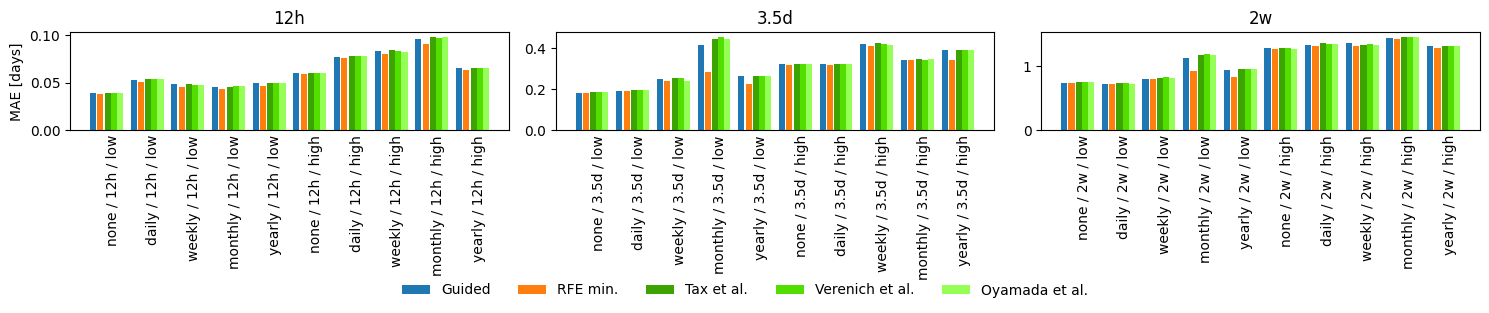

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(15,3), sharey=False)

dataset_groups = {
    "12h":   internal_validation_df[internal_validation_df.index.str.contains("12h")],
    "3.5d":  internal_validation_df[internal_validation_df.index.str.contains("3.5d")],
    "2w":    internal_validation_df[internal_validation_df.index.str.contains("2w")],
}

feature_groups = ["Guided", "RFE min.", "Tax et al.", "Verenich et al.", "Oyamada et al."]
colors = {
    "Guided":         "#1f77b4",   # strong blue
    "RFE min.":       "#ff7f0e",   # strong orange
    #"RFE max.":        "#ffbb78",   # light orange
    "Tax et al.":     "#3ca300",   
    "Verenich et al.":"#52df00",   
    "Oyamada et al.": "#95ff58",   
}


width   = 0.15

for ax, (label, subdf) in zip(axes, dataset_groups.items()):
    x = range(len(subdf))

    # small extra gap to insert between bar 0&1 and bar 1&2
    extra_gap = width * 0.2
    offsets = [
        -1.5 * width - extra_gap,  # first bar (shifted left a bit more)
        -0.5 * width,              # second bar
         0.5 * width + extra_gap,  # third bar (shifted right a bit more)
         1.5 * width + extra_gap,  # fourth bar (keeps the extra offset)
         2.5 * width + extra_gap,  # fifth bar (keeps the extra offset)
    ]

    for i, m in enumerate(feature_groups):
        positions = [p + offsets[i] for p in x]
        ax.bar(positions, subdf[m]/3600/24, width=width, label=m, color=colors[m])

    ax.set_title(label)
    ax.set_xticks(list(x))
    ax.set_xticks([p + 0.4 for p in x]) # shift x-labels in place
    ax.tick_params(axis='x', length=0)  # remove x-ticks
    ax.set_xticklabels(subdf.index, rotation=90, ha="right")

axes[0].set_ylabel("MAE [days]")

# Get legend handles
handles, labels = axes[0].get_legend_handles_labels()

# Create horizontal legend below the plots
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    bbox_to_anchor=(0.5, -0.05),
    frameon=False
)

plt.tight_layout()
plt.show()


In [120]:
print("Guided vs. RFE")
print((internal_validation_df["Guided"] / internal_validation_df["RFE min."]-1).describe())

Guided vs. RFE
count    30.000000
mean      0.058178
std       0.093489
min       0.000473
25%       0.011429
50%       0.026694
75%       0.054014
max       0.462719
dtype: float64


In [121]:
print("Guided vs Tax et al.")
print((internal_validation_df["Guided"] / internal_validation_df["Tax et al."]-1).describe())
 
print("\nGuided vs Verenich et al.")
print((internal_validation_df["Guided"] / internal_validation_df["Verenich et al."]-1).describe())

print("\nGuided vs Oyamada et al.")
print((internal_validation_df["Guided"] / internal_validation_df["Oyamada et al."]-1).describe())

Guided vs Tax et al.
count    30.000000
mean     -0.012182
std       0.015119
min      -0.063816
25%      -0.018045
50%      -0.008595
75%      -0.003634
max       0.020666
dtype: float64

Guided vs Verenich et al.
count    30.000000
mean     -0.011341
std       0.018058
min      -0.084326
25%      -0.016241
50%      -0.006418
75%      -0.000398
max       0.005139
dtype: float64

Guided vs Oyamada et al.
count    30.000000
mean     -0.006328
std       0.019999
min      -0.060194
25%      -0.016326
50%      -0.004821
75%       0.001670
max       0.053370
dtype: float64


In [122]:
print("RFE vs Tax et al.")
print((internal_validation_df["RFE min."] / internal_validation_df["Tax et al."]-1).describe())

print("\nRFE vs Verenich et al.")
print((internal_validation_df["RFE min."] / internal_validation_df["Verenich et al."]-1).describe())

print("\nRFE vs Oyamada et al.")
print((internal_validation_df["RFE min."] / internal_validation_df["Oyamada et al."]-1).describe())

RFE vs Tax et al.
count    30.000000
mean     -0.060236
std       0.074127
min      -0.359970
25%      -0.063005
50%      -0.032765
75%      -0.019830
max      -0.010388
dtype: float64

RFE vs Verenich et al.
count    30.000000
mean     -0.059186
std       0.076921
min      -0.373992
25%      -0.059833
50%      -0.028612
75%      -0.020535
max      -0.006260
dtype: float64

RFE vs Oyamada et al.
count    30.000000
mean     -0.054640
std       0.075739
min      -0.357494
25%      -0.060962
50%      -0.025033
75%      -0.017737
max       0.000257
dtype: float64


## External validity

In [123]:
RFE_RESULTS_PATHS = {
    'BPI 2012 (A)': Path('../artifacts/recursive_feature_elimination/BPI_2012_A/pi_rfe_results_20251116T231419Z.json'),
    'BPI 2012 (O)': Path('../artifacts/recursive_feature_elimination/BPI_2012_O/pi_rfe_results_20251117T013615Z.json'),
    'BPI 2012 (W)': Path('../artifacts/recursive_feature_elimination/BPI_2012_W/pi_rfe_results_20251117T200814Z.json'),
    'BPI 2013 (closed problems)': Path('../artifacts/recursive_feature_elimination/BPI_2013_closed_problems/pi_rfe_results_20251110T172643Z.json'),
    'Helpdesk': Path('../artifacts/recursive_feature_elimination/helpdesk/pi_rfe_results_20251110T212810Z.json'),
    'Prepaid travel cost': Path('../artifacts/recursive_feature_elimination/prepaid_travel_cost/pi_rfe_results_20251117T025626Z.json'),
    'Request for payment': Path('../artifacts/recursive_feature_elimination/request_for_payment/pi_rfe_results_20251117T045944Z.json'),
    'Sepsis': Path('../artifacts/recursive_feature_elimination/sepsis/pi_rfe_results_20251125T131211Z.json'),
    }

In [124]:
GUIDED_RESULTS_PATHS_v05 = {
    'BPI 2012 (A)': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_BPI_2012_A.xes_20251118_174337.json'),
    'BPI 2012 (O)': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_BPI_2012_O.xes_20251118_183200.json'),
    'BPI 2012 (W)': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_BPI_2012_W.xes_20251118_182732.json'),
    'BPI 2013 (closed problems)': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_BPI_2013_closed_problems.xes_20251112_091812.json'),
    'Helpdesk': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_helpdesk.xes_20251112_091703.json'),
    'Prepaid travel cost': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_prepaid_travel_cost.xes_20251118_182856.json'),
    'Request for payment': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_request_for_payment.xes_20251118_181343.json'),
    'Sepsis': Path('../artifacts/validation/external/guided_v05/summary_validation_guided_sepsis.xes_20251125_181503.json'),
    }

In [125]:
GUIDED_RESULTS_PATHS = GUIDED_RESULTS_PATHS_v05

In [126]:
TAX_RESULTS_PATHS = {
    'BPI 2012 (A)': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_BPI_2012_A.xes_20251118_114935.json'),
    'BPI 2012 (O)': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_BPI_2012_O.xes_20251118_120330.json'),
    'BPI 2012 (W)': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_BPI_2012_W.xes_20251118_115829.json'),
    'BPI 2013 (closed problems)': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_BPI_2013_closed_problems.xes_20251111_160112.json'),
    'Helpdesk': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_helpdesk.xes_20251111_155934.json'),
    'Prepaid travel cost': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_prepaid_travel_cost.xes_20251118_115935.json'),
    'Request for payment': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_request_for_payment.xes_20251118_115141.json'),
    'Sepsis': Path('../artifacts/validation/external/tax_etal/summary_validation_tax_sepsis.xes_20251125_161834.json'),
    }   

VERENICH_RESULTS_PATHS = {
    'BPI 2012 (A)': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_BPI_2012_A.xes_20251118_120711.json'),
    'BPI 2012 (O)': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_BPI_2012_O.xes_20251118_123025.json'),
    'BPI 2012 (W)': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_BPI_2012_W.xes_20251118_122629.json'),
    'BPI 2013 (closed problems)': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_BPI_2013_closed_problems.xes_20251111_210135.json'),
    'Helpdesk': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_helpdesk.xes_20251111_205956.json'),
    'Prepaid travel cost': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_prepaid_travel_cost.xes_20251118_122727.json'),
    'Request for payment': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_request_for_payment.xes_20251118_121402.json'),
    'Sepsis': Path('../artifacts/validation/external/verenich_etal/summary_validation_verenich_sepsis.xes_20251125_161920.json'),
    }   

OYAMADA_RESULTS_PATHS = {
    'BPI 2012 (A)': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_BPI_2012_A.xes_20251118_123242.json'),
    'BPI 2012 (O)': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_BPI_2012_O.xes_20251118_124622.json'),
    'BPI 2012 (W)': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_BPI_2012_W.xes_20251118_124405.json'),
    'BPI 2013 (closed problems)': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_BPI_2013_closed_problems.xes_20251118_121811.json'),
    'Helpdesk': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_helpdesk.xes_20251118_123907.json'),
    'Prepaid travel cost': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_prepaid_travel_cost.xes_20251118_124458.json'),
    'Request for payment': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_request_for_payment.xes_20251118_123726.json'),
    'Sepsis': Path('../artifacts/validation/external/oyamada_etal/summary_validation_oyamada_sepsis.xes_20251125_162013.json'),
}

external_validation_df = pd.DataFrame([], columns=["Dataset"]).set_index("Dataset")


In [127]:
# Read results from RFE
rows = []
for dataset, path in RFE_RESULTS_PATHS.items():
    rfe_df = extract_rfe_results(path, dataset)
    vals = rfe_df["baseline_metric"].dropna().to_numpy()
    if vals.size == 0:
        rows.append({
            "dataset": dataset,
            "RFE min.": np.nan,
            "RFE p25": np.nan,
            "RFE p50": np.nan,
            "RFE p75": np.nan,
            "RFE max.": np.nan,
            "RFE mean": np.nan,
        })
    else:
        rows.append({
            "dataset": dataset,
            "RFE min.": float(np.min(vals)),
            "RFE p25": float(np.nanpercentile(vals, 25)),
            "RFE p50": float(np.nanpercentile(vals, 50)),
            "RFE p75": float(np.nanpercentile(vals, 75)),
            "RFE max.": float(np.max(vals)),
            "RFE mean": float(np.mean(vals)),
        })

external_validation_df = pd.DataFrame(rows).set_index("dataset")
        
for dataset, path in GUIDED_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    external_validation_df.loc[dataset, "Guided"] = mae


for dataset, path in TAX_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    external_validation_df.loc[dataset, "Tax et al."] = mae

for dataset, path in VERENICH_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    external_validation_df.loc[dataset, "Verenich et al."] = mae

for dataset, path in OYAMADA_RESULTS_PATHS.items():
    mae = extract_single_results(path, dataset)
    external_validation_df.loc[dataset, "Oyamada et al."] = mae

external_validation_df

C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\3092073739.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\3092073739.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rank_df = pd.concat([elim_df, not_removed_df], ignore_index=True, sort=False)
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\3092073739.py:75: FutureWarning: The behavior of DataFrame c

,RFE min.,RFE p25,RFE p50,RFE p75,RFE max.,RFE mean,Guided,Tax et al.,Verenich et al.,Oyamada et al.
dataset,,,,,,,,,,
BPI 2012 (A),6.970131e+05,7.089395e+05,7.108496e+05,7.143736e+05,7.229472e+05,7.113222e+05,6.848575e+05,6.855940e+05,6.864998e+05,6.852106e+05
BPI 2012 (O),6.210159e+05,6.330257e+05,6.362515e+05,6.405751e+05,6.882637e+05,6.377379e+05,6.214673e+05,6.260742e+05,6.256523e+05,6.278312e+05
BPI 2012 (W),8.246436e+05,8.599646e+05,8.748411e+05,8.993473e+05,9.162761e+05,8.766842e+05,7.487104e+05,7.289739e+05,7.281633e+05,7.263903e+05
BPI 2013 (closed problems),4.862378e+06,5.151242e+06,5.217458e+06,5.360347e+06,8.099928e+06,5.483037e+06,5.023634e+06,5.303292e+06,5.178242e+06,5.256376e+06
Helpdesk,3.848665e+05,4.081163e+05,4.242078e+05,4.387470e+05,4.625162e+05,4.227326e+05,3.912651e+05,4.435856e+05,4.337443e+05,4.353116e+05
Prepaid travel cost,1.293409e+06,1.303729e+06,1.313998e+06,1.324785e+06,1.371532e+06,1.318162e+06,1.255876e+06,1.256788e+06,1.257808e+06,1.259590e+06
Request for payment,5.704677e+05,5.762415e+05,5.787142e+05,5.821485e+05,5.877689e+05,5.794321e+05,5.700316e+05,5.682743e+05,5.697393e+05,5.567389e+05
Sepsis,5.535144e+06,5.573395e+06,5.585327e+06,5.600628e+06,5.639045e+06,5.586276e+06,5.545328e+06,5.534414e+06,5.533731e+06,5.541286e+06


C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\2873767056.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=0, ha="right")
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\2873767056.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=0, ha="right")
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\2873767056.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, rotation=0, ha="right")
C:\Users\m711912\AppData\Local\Temp\ipykernel_32812\2873767056.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subdf.index, 

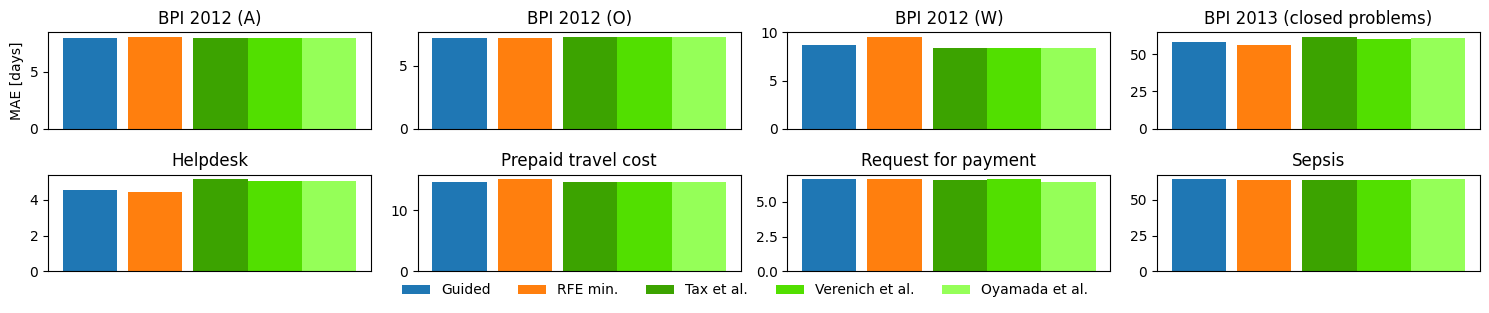

In [128]:
fig, axes = plt.subplots(2, 4, figsize=(15,3), sharey=False)
axes = axes.ravel()

dataset_groups = {
    #"BPI 2012 W (sample)":   external_validation_df[external_validation_df.index.str.startswith("BPI 2012 W (sample)")],
    #"BPI 2017 W (sample)":   external_validation_df[external_validation_df.index.str.startswith("BPI 2017 W (sample)")],

    "BPI 2012 (A)":   external_validation_df[external_validation_df.index.str.startswith("BPI 2012 (A)")],
    "BPI 2012 (O)":   external_validation_df[external_validation_df.index.str.startswith("BPI 2012 (O)")],
    "BPI 2012 (W)":   external_validation_df[external_validation_df.index.str.startswith("BPI 2012 (W)")],
    "BPI 2013 (closed problems)":   external_validation_df[external_validation_df.index.str.startswith("BPI 2013 (closed problems)")],
    "Helpdesk": external_validation_df[external_validation_df.index.str.startswith("Helpdesk")],
    "Prepaid travel cost": external_validation_df[external_validation_df.index.str.startswith("Prepaid travel cost")],
    "Request for payment": external_validation_df[external_validation_df.index.str.startswith("Request for payment")],    
    "Sepsis": external_validation_df[external_validation_df.index.str.startswith("Sepsis")],    
}

feature_groups = ["Guided", "RFE min.", "Tax et al.", "Verenich et al.", "Oyamada et al."]
colors = {
    "Guided":         "#1f77b4",   # strong blue
    "RFE min.":       "#ff7f0e",   # strong orange
    #"RFE max.":        "#ffbb78",   # light orange
    "Tax et al.":     "#3ca300",
    "Verenich et al.":"#52df00",
    "Oyamada et al.": "#95ff58",   
}


width   = 0.15

for ax, (label, subdf) in zip(axes, dataset_groups.items()):
    x = range(len(subdf))

    # small extra gap to insert between bar 0&1 and bar 1&2
    extra_gap = width * 0.2
    offsets = [
        -1.5 * width - extra_gap,  # first bar (shifted left a bit more)
        -0.5 * width,              # second bar
         0.5 * width + extra_gap,  # third bar (shifted right a bit more)
         1.5 * width + extra_gap,  # fourth bar (keeps the extra offset)
         2.5 * width + extra_gap,  # fourth bar (keeps the extra offset)
    ]

    for i, m in enumerate(feature_groups):
        positions = [p + offsets[i] for p in x]
        ax.bar(positions, subdf[m]/3600/24, width=width, label=m, color=colors[m])

    ax.set_title(label)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xticklabels(subdf.index, rotation=0, ha="right")
    ax.set_ylim(auto=True)

for ax in axes[len(dataset_groups):]:
    ax.set_visible(False)

axes[0].set_ylabel("MAE [days]")

# Get legend handles
handles, labels = axes[0].get_legend_handles_labels()

# Create horizontal legend below
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=len(labels),
    bbox_to_anchor=(0.5, -0.05),
    frameon=False
)

plt.tight_layout()
plt.show()


In [129]:
print("Guided vs. RFE")
print((external_validation_df["Guided"] / external_validation_df["RFE min."]-1).map("{:.3f}".format))
print((external_validation_df["Guided"] / external_validation_df["RFE min."]-1).describe().map("{:.3f}".format))

Guided vs. RFE
dataset
BPI 2012 (A)                  -0.017
BPI 2012 (O)                   0.001
BPI 2012 (W)                  -0.092
BPI 2013 (closed problems)     0.033
Helpdesk                       0.017
Prepaid travel cost           -0.029
Request for payment           -0.001
Sepsis                         0.002
dtype: object
count     8.000
mean     -0.011
std       0.038
min      -0.092
25%      -0.020
50%      -0.000
75%       0.006
max       0.033
dtype: object


In [130]:
print("------\nGuided vs Tax et al.\n------")
print((external_validation_df["Guided"] / external_validation_df["Tax et al."]-1).map("{:.3f}".format), "\n")
print((external_validation_df["Guided"] / external_validation_df["Tax et al."]-1).describe().map("{:.3f}".format))

print("\n------\nGuided vs Verenich et al.\n------")
print((external_validation_df["Guided"] / external_validation_df["Verenich et al."]-1).map("{:.3f}".format))
print((external_validation_df["Guided"] / external_validation_df["Verenich et al."]-1).describe().map("{:.3f}".format))

print("\n------\nGuided vs Oyamada et al.\n------")
print((external_validation_df["Guided"] / external_validation_df["Oyamada et al."]-1).map("{:.3f}".format))
print((external_validation_df["Guided"] / external_validation_df["Oyamada et al."]-1).describe().map("{:.3f}".format))

------
Guided vs Tax et al.
------
dataset
BPI 2012 (A)                  -0.001
BPI 2012 (O)                  -0.007
BPI 2012 (W)                   0.027
BPI 2013 (closed problems)    -0.053
Helpdesk                      -0.118
Prepaid travel cost           -0.001
Request for payment            0.003
Sepsis                         0.002
dtype: object 

count     8.000
mean     -0.018
std       0.046
min      -0.118
25%      -0.019
50%      -0.001
75%       0.002
max       0.027
dtype: object

------
Guided vs Verenich et al.
------
dataset
BPI 2012 (A)                  -0.002
BPI 2012 (O)                  -0.007
BPI 2012 (W)                   0.028
BPI 2013 (closed problems)    -0.030
Helpdesk                      -0.098
Prepaid travel cost           -0.002
Request for payment            0.001
Sepsis                         0.002
dtype: object
count     8.000
mean     -0.013
std       0.038
min      -0.098
25%      -0.012
50%      -0.002
75%       0.001
max       0.028
dtype: object

-

In [131]:
print("Tax et al. vs Verenich et al.")
print((external_validation_df["Tax et al."] / external_validation_df["Verenich et al."]-1).map("{:.3f}".format))
print((external_validation_df["Tax et al."] / external_validation_df["Verenich et al."]-1).describe().map("{:.3f}".format))

Tax et al. vs Verenich et al.
dataset
BPI 2012 (A)                  -0.001
BPI 2012 (O)                   0.001
BPI 2012 (W)                   0.001
BPI 2013 (closed problems)     0.024
Helpdesk                       0.023
Prepaid travel cost           -0.001
Request for payment           -0.003
Sepsis                         0.000
dtype: object
count     8.000
mean      0.006
std       0.011
min      -0.003
25%      -0.001
50%       0.000
75%       0.007
max       0.024
dtype: object
